In [1]:
!pip install scikit-learn==1.0

     |████████████████████████████████| 23.1 MB 1.7 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


## 6.10 Homework

The goal of this homework is to create a tree-based regression model for prediction apartment prices (column `'price'`).

In this homework we'll again use the New York City Airbnb Open Data dataset - the same one we used in homework 2 and 3.

You can take it from [Kaggle](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data?select=AB_NYC_2019.csv)
or download from [here](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv)
if you don't want to sign up to Kaggle.

Let's load the data:

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor, export_text, export_graphviz
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import xgboost as xgb

import graphviz
from IPython.display import display, clear_output

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

* Use only the following columns:
 * `neighbourhood_group`,
 * `room_type`,
 * `latitude`,
 * `longitude`,
 * `minimum_nights`,
 * `number_of_reviews`,
 * `reviews_per_month`,
 * `calculated_host_listings_count`,
 * `availability_365`,
 * `price`
* Fill NAs with 0
* Apply the log tranform to `price`
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1

In [3]:
columns = [
    'neighbourhood_group', 'room_type', 'latitude', 'longitude',
    'minimum_nights', 'number_of_reviews','reviews_per_month',
    'calculated_host_listings_count', 'availability_365',
    'price'
]

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv', usecols=columns)

In [5]:
df.reviews_per_month = df.reviews_per_month.fillna(0)
df['price'] = np.log1p(df['price'])
df.head()

,neighbourhood_group,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,40.64749,-73.97237,Private room,5.010635,1,9,0.21,6,365
1,Manhattan,40.75362,-73.98377,Entire home/apt,5.420535,1,45,0.38,2,355
2,Manhattan,40.80902,-73.94190,Private room,5.017280,3,0,0.00,1,365
3,Brooklyn,40.68514,-73.95976,Entire home/apt,4.499810,1,270,4.64,1,194
4,Manhattan,40.79851,-73.94399,Entire home/apt,4.394449,10,9,0.10,1,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   neighbourhood_group             48895 non-null  object 
 1   latitude                        48895 non-null  float64
 2   longitude                       48895 non-null  float64
 3   room_type                       48895 non-null  object 
 4   price                           48895 non-null  float64
 5   minimum_nights                  48895 non-null  int64  
 6   number_of_reviews               48895 non-null  int64  
 7   reviews_per_month               48895 non-null  float64
 8   calculated_host_listings_count  48895 non-null  int64  
 9   availability_365                48895 non-null  int64  
dtypes: float64(4), int64(4), object(2)
memory usage: 3.7+ MB


In [6]:
full_train, test = train_test_split(df, test_size=0.2, random_state=1)
train, val = train_test_split(full_train, test_size=0.25, random_state=1)

len(train), len(val), len(test)

(29337, 9779, 9779)

In [7]:
train = train.reset_index(drop=True)
val = val.reset_index(drop=True)
test = test.reset_index(drop=True)

y_train = train.price.values
y_val = val.price.values
y_test = test.price.values

del train['price']
del val['price']
del test['price']

Now, use `DictVectorizer` to turn train and validation into matrices:

In [8]:
dv = DictVectorizer(sparse=False)

train_dict = train.to_dict(orient='records')
val_dict = val.to_dict(orient='records')

X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)

## Question 1

Let's train a decision tree regressor to predict the price variable. 

* Train a model with `max_depth=1`

In [9]:
dtregr = DecisionTreeRegressor(max_depth=1)

dtregr.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [ ]:
features

array(['availability_365', 'calculated_host_listings_count', 'latitude',
       'longitude', 'minimum_nights', 'neighbourhood_group=Bronx',
       'neighbourhood_group=Brooklyn', 'neighbourhood_group=Manhattan',
       'neighbourhood_group=Queens', 'neighbourhood_group=Staten Island',
       'number_of_reviews', 'reviews_per_month',
       'room_type=Entire home/apt', 'room_type=Private room',
       'room_type=Shared room'], dtype=object)

In [10]:
features = dv.get_feature_names_out()
print(export_text(dtregr, feature_names=list(features)))

|--- room_type=Entire home/apt <= 0.50
|   |--- value: [4.29]
|--- room_type=Entire home/apt >  0.50
|   |--- value: [5.15]



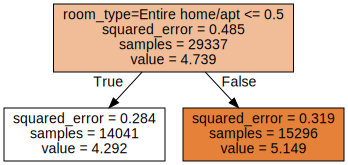

In [11]:
export_graphviz(dtregr, out_file='decision_tree.dot', feature_names=features, filled=True)

with open('decision_tree.dot') as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

Which feature is used for splitting the data?

* `room_type`
* `neighbourhood_group`
* `number_of_reviews`
* `reviews_per_month`

## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1`  (optional - to make training faster)

In [ ]:
rfregr = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rfregr.fit(X_train, y_train)
prediction = rfregr.predict(X_val)
rmse = mean_squared_error(y_val, prediction, squared=False)
print(rmse)

0.4598535778342608


What's the RMSE of this model on validation?

* 0.059
* 0.259
* 0.459
* 0.659

## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10
* Set `random_state` to `1`

In [ ]:
def evaluate(n_estimators, max_depth, random_state=1):
    rf = RandomForestRegressor(n_estimators=n_estimators, 
                               max_depth=max_depth, 
                               random_state=random_state, 
                               n_jobs=-1)
    rf.fit(X_train, y_train)
    prediction = rf.predict(X_val)
    rmse = mean_squared_error(y_val, prediction, squared=False)

    return rmse

In [ ]:
n_estimators_ = np.arange(10, 210, 10)
scores = [(n, evaluate(n_estimators=n, max_depth=None)) for n in n_estimators_]

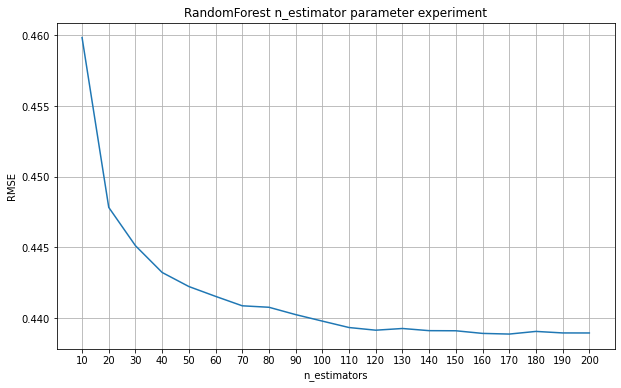

In [ ]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

fig = plt.figure(figsize=(10, 6))
plt.plot(df_scores.n_estimators, df_scores.rmse)
plt.xlabel('n_estimators')
plt.ylabel('RMSE')
plt.xticks(n_estimators_)
plt.title('RandomForest n_estimator parameter experiment')
plt.grid();

After which value of `n_estimators` does RMSE stop improving?

- 10
- 50
- 70
- 120

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
* Fix the random seed: `random_state=1`

In [ ]:
random_state_ = 1
max_depth_ = [10, 15, 20, 25]
scores = [(d, n, evaluate(n_estimators=n, max_depth=d, random_state=random_state_)) for d in max_depth_ for n in n_estimators_]

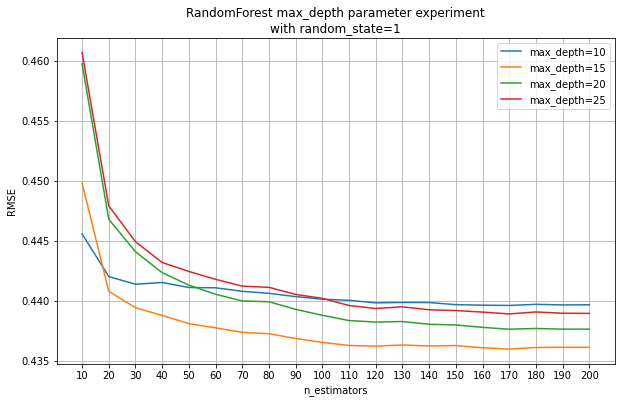

In [ ]:
df_scores = pd.DataFrame(scores, columns=['max_depth', 'n_estimators', 'rmse'])

fig = plt.figure(figsize=(10, 6))

for d in max_depth_:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.rmse,
             label=f'max_depth={d}')

plt.xlabel('n_estimators')
plt.ylabel('RMSE')
plt.xticks(n_estimators_)
plt.title(f'RandomForest max_depth parameter experiment\nwith random_state={random_state_}')
plt.grid()
plt.legend();

What's the best `max_depth`:

* 10
* 15
* 20
* 25


In [ ]:
df_scores.max_depth[df_scores.rmse.argmin()]

15

**Bonus question** (not graded):

Will the answer be different if we change the seed for the model?

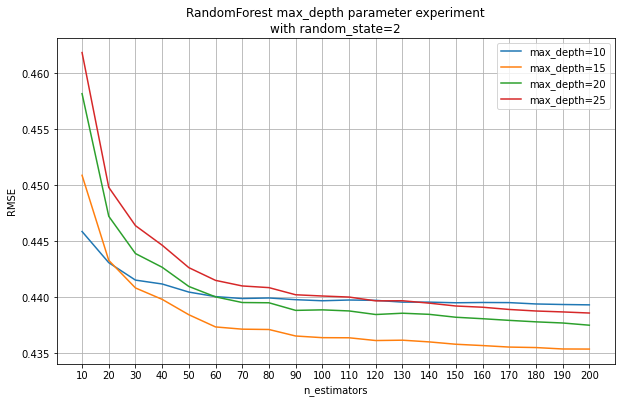

In [ ]:
random_state_ = 2
scores = [(d, n, evaluate(n_estimators=n, max_depth=d, random_state=random_state_)) for d in max_depth_ for n in n_estimators_]

df_scores = pd.DataFrame(scores, columns=['max_depth', 'n_estimators', 'rmse'])

fig = plt.figure(figsize=(10, 6))

for d in max_depth_:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.rmse,
             label=f'max_depth={d}')

plt.xlabel('n_estimators')
plt.ylabel('RMSE')
plt.xticks(n_estimators_)
plt.title(f'RandomForest max_depth parameter experiment\nwith random_state={random_state_}')
plt.grid()
plt.legend();

## Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorith, it finds the best split. 
When doint it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the imporatant features 
for tree-based models.

In Scikit-Learn, tree-based models contain this information in the `feature_importances_` field. 

For this homework question, we'll find the most important feature:

* Train the model with these parametes:
    * `n_estimators=10`,
    * `max_depth=20`,
    * `random_state=1`,
    * `n_jobs=-1` (optional)
* Get the feature importance information from this model

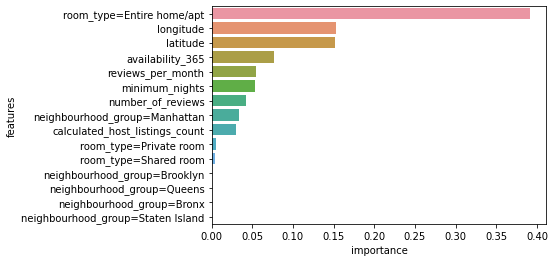

In [ ]:
rf = RandomForestRegressor(n_estimators=10, 
                           max_depth=20, 
                           random_state=1, 
                           n_jobs=-1)
rf.fit(X_train, y_train)

importances = rf.feature_importances_

df_importances = pd.DataFrame([(f, i) for f, i in zip(features, importances)],
                              columns=['features', 'importance'])
df_importances.sort_values(by='importance', ascending=False, inplace=True)
sns.barplot(data=df_importances, y='features', x='importance');

What's the most important feature? 

* `neighbourhood_group=Manhattan`
* `room_type=Entire home/apt`	
* `longitude`
* `latitude`

In [ ]:
features[np.argmax(importances)]

'room_type=Entire home/apt'

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

In [ ]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_rmse', 'val_rmse']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)
watchlist = [(dtrain, 'train'), (dval, 'val')]

xgb_params = {
    'eta':0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'reg:squarederror',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

scores = dict()

In [ ]:
%%capture output
model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5,
                  evals=watchlist)

In [ ]:
key = f'eta={xgb_params["eta"]}'
scores[key] = parse_xgb_output(output)

Now change `eta` first to `0.1` and then to `0.01`

In [ ]:
xgb_params["eta"] = 0.1

In [ ]:
%%capture output
model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5,
                  evals=watchlist)

In [ ]:
key = f'eta={xgb_params["eta"]}'
scores[key] = parse_xgb_output(output)

In [ ]:
xgb_params["eta"] = 0.01

In [ ]:
%%capture output
model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5,
                  evals=watchlist)

In [ ]:
key = f'eta={xgb_params["eta"]}'
scores[key] = parse_xgb_output(output)

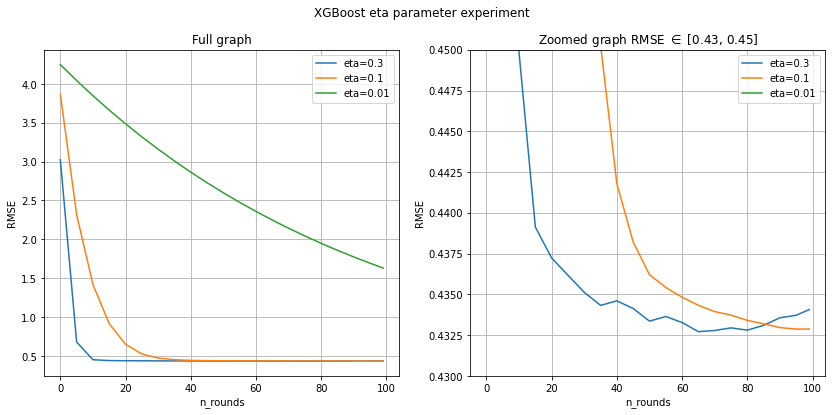

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for eta, df_score in scores.items():
    axes[0].plot(df_score.num_iter, df_score.val_rmse, label=eta)

    axes[0].set_xlabel('n_rounds')
    axes[0].set_ylabel('RMSE')
    axes[0].grid()
    axes[0].legend()
    axes[0].set_title('Full graph')

    high, low = 0.45, 0.43
    axes[1].plot(df_score.num_iter, df_score.val_rmse, label=eta)
    axes[1].set_xlabel('n_rounds')
    axes[1].set_ylabel('RMSE')
    axes[1].set_ylim(low, high)
    axes[1].grid()
    axes[1].legend()
    axes[1].set_title(f'Zoomed graph RMSE $\in$ [{low}, {high}]')

plt.suptitle(f'XGBoost eta parameter experiment');

What's the best eta?

* 0.3
* 0.1
* 0.01

<blockquote class="twitter-tweet"><p lang="en" dir="ltr"><a href="https://twitter.com/hashtag/DataTalksClub?src=hash&amp;ref_src=twsrc%5Etfw">#DataTalksClub</a> <a href="https://twitter.com/hashtag/MLZoomcamp?src=hash&amp;ref_src=twsrc%5Etfw">#MLZoomcamp</a> my favorite Decesion Trees in Homework #6!</p>&mdash; sha of smile (@trueRock_n_roll) <a href="https://twitter.com/trueRock_n_roll/status/1448528594297401347?ref_src=twsrc%5Etfw">October 14, 2021</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>

## Submit the results


Submit your results here: https://forms.gle/wQgFkYE6CtdDed4w8

It's possible that your answers won't match exactly. If it's the case, select the closest one.


## Deadline


The deadline for submitting is 20 October 2021, 17:00 CET (Wednesday). After that, the form will be closed.

